In [17]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import os
import sys
from chimera import Chimera

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [37]:
# load experimental data
data = pd.read_csv('big1.csv')
data.loc[:, 'WL_transformed'] = np.abs(data.loc[:, 'WL'] - 540)  # target is 540 +/- 2
data

,#,HAuCl4,PVP,Glucose,NaOH,Time,A450,WL,FWHM,R,std,WL_transformed
0,1,19.36,20.00,9.78,19.94,3.09,0.17,520.5,118.0,6.42,0.00168 0.5 0. 0.17,19.5
1,2,9.86,7.80,5.33,11.35,8.56,0.07,525.0,117.0,5.64,0.003845 0. 1. 0.015,15.0
2,3,9.63,13.45,4.30,8.72,9.91,0.02,522.0,119.0,4.74,9.10e-04 1.00e+00 3.00e+00 7.55e-01,18.0
3,4,12.24,19.52,19.21,19.79,5.68,0.11,526.5,120.0,5.36,1.26e-03 5.00e-01 2.00e+00 4.65e-01,13.5
4,5,11.48,18.98,19.88,19.14,6.06,0.10,529.0,129.0,4.40,0.00464 1. 1. 0.195,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,13.53,12.74,15.37,7.59,7.36,0.04,540.5,149.0,2.52,2.005e-03 5.000e-01 3.000e+00 4.500e-02,0.5
96,97,16.01,10.73,16.57,19.90,4.84,0.11,544.5,142.0,2.37,3.05e-04 5.00e-01 2.00e+00 5.00e-02,4.5
97,98,12.48,9.39,15.91,14.57,2.83,0.08,548.0,152.0,2.02,0.00307 0. 2. 0.035,8.0
98,99,14.95,10.28,17.62,20.00,4.57,0.11,548.0,142.0,2.20,9.9e-04 1.0e+00 2.0e+00 2.0e-02,8.0


## Process data to get relevant info

In [5]:
# define multi-objective preferences
chimera = Chimera(tolerances=[2, 0.4, 0.0], absolutes=[True, False, False], goals=['min', 'min', 'max'])

# Get index of best solution at each experimental iteration
best_indices = []
for i in data.index:
    # consider objectives for experiments up to i
    objectives = data.loc[:i, ['WL_transformed', 'FWHM', 'A450']]
    # scalarize objectives
    scalarized = chimera.scalarize(objectives)
    # save index of best up to i
    best_idx = np.argmin(scalarized)
    best_indices.append(best_idx)
    
# get history of objectives for best solution
obj_1 = [data.loc[:i, 'WL_transformed'].to_numpy()[i] for i in best_indices]
obj_2 = [data.loc[:i, 'FWHM'].to_numpy()[i] for i in best_indices]
obj_3 = [data.loc[:i, 'A450'].to_numpy()[i] for i in best_indices]

In [8]:
# get dynamic/relative 0.4 threshoold for FWHM
min_fwhm_list = []
max_fwhm_list = []
thr_fwhm_list = []

for i in data.index:
    min_fwhm = data.loc[:i, 'FWHM'].min()
    max_fwhm = data.loc[:i, 'FWHM'].max()
    thr_fwhm = min_fwhm + (max_fwhm - min_fwhm) * 0.4
    min_fwhm_list.append(min_fwhm)
    max_fwhm_list.append(max_fwhm)
    thr_fwhm_list.append(thr_fwhm)
    

# get final/last 0.4 threshoold for FWHM
min_fwhm = data.loc[:, 'FWHM'].min()
max_fwhm = data.loc[:, 'FWHM'].max()
thres_fwhm = data.loc[:, 'FWHM'].min() + (max_fwhm - min_fwhm) * 0.4

## Three 1D plots

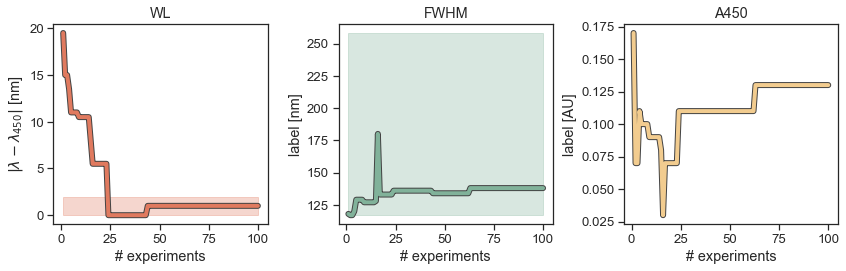

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

experiment_nums = range(1, len(data)+1, 1)  # for x-axis

# colors
c1 = '#e07a5f'
c2 = '#81b29a'
c3 = '#f2cc8f'

# -----------
# plot traces
# -----------
ax1.plot(experiment_nums, obj_1, color='#444444', linewidth=6)
ax1.plot(experiment_nums, obj_1, color=c1, linewidth=4)

ax2.plot(experiment_nums, obj_2, color='#444444', linewidth=6)
ax2.plot(experiment_nums, obj_2, color=c2, linewidth=4)

ax3.plot(experiment_nums, obj_3, color='#444444', linewidth=6)
ax3.plot(experiment_nums, obj_3, color=c3, linewidth=4)

# -------------------------------------
# plot target region for the objectives 
# -------------------------------------
ax1.fill_between(x=experiment_nums, y1=0.0, y2=2.0, color=c1, alpha=0.3)

ax2.fill_between(x=experiment_nums, y1=min_fwhm, y2=thr_fwhm, color=c2, alpha=0.3)  # simpler
#ax2.fill_between(x=experiment_nums, y1=min_fwhm_list, y2=thr_fwhm_list, color=c2, alpha=0.3)  # perhaps more accurate


# titles and labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('# experiments')
    
ax1.set_title('WL')
ax2.set_title('FWHM')
ax3.set_title('A450')

ax1.set_ylabel('$|\lambda - \lambda_{450}|$ [nm]')
ax2.set_ylabel('label [nm]')
ax3.set_ylabel('label [AU]')
    
plt.tight_layout()
#fig.savefig("objectives_plot.pdf", bbox_inches='tight')

## 3D plot

In [151]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def cuboid_data(pos, size=(1,1,1)):
    # code taken from
    # https://stackoverflow.com/a/35978146/4124317
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(pos, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(ax=None, pos=(0,0,0), size=(1,1,1)):
    # Plotting a cube element at position pos
    if ax !=None:
        

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 4. * np.pi, 100)
    y = np.sin(x)
    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap='hsv')
    plt.colorbar(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

Text(0.5, 0, 'A450 [AU]')

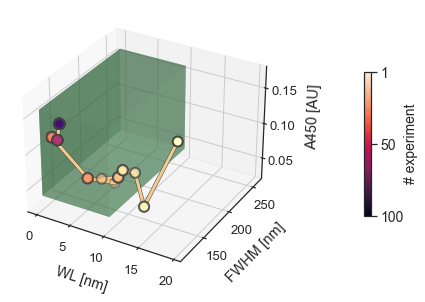

In [240]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection='3d')

ax.plot(obj_1, obj_2, obj_3, linewidth=4, color='#444444')
ax.plot(obj_1, obj_2, obj_3, linewidth=3, color='#f2cc8f')

cmap = plt.cm.magma_r(np.linspace(0, 1, len(obj_1)))
sc = ax.scatter(obj_1, obj_2, obj_3, s=100, c=cmap, edgecolor='#444444', linewidth=2)

#fig.colorbar(sc, shrink=0.5, pad=0.15)
# Add colorbar
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([1.0, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
colorbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
_ = colorbar.set_label('# experiment', fontsize=14, labelpad=0.1)
_ = colorbar.set_ticks([0, 0.5, 1])
_ = colorbar.set_ticklabels(['100','50','1'])
_ = cbar_ax.tick_params(labelsize=14) 

# plot rectangle that shows target area
xlims = [0, 10]
ylims = [min_fwhm, thr_fwhm]
zlims = [0.04, 0.16]
centers = (np.mean(xlims), np.mean(ylims), np.mean(zlims))
len_edges = (np.max(xlims)-np.min(xlims), np.max(ylims)-np.min(ylims), np.max(zlims)-np.min(zlims))
X, Y, Z = cuboid_data(pos=centers, size=len_edges)

ax.plot_surface(X, Y, Z, color='g', alpha=0.3, linewidth=0)

# labels
ax.set_xlabel('WL [nm]', labelpad=10)
ax.set_ylabel('FWHM [nm]', labelpad=10)
ax.set_zlabel('A450 [AU]', labelpad=10)

#plt.tight_layout()
#fig.savefig("3d_plot.pdf", bbox_inches='tight')